## CSE 8803: Brain-inspired Machine Intelligence

### Lab 1: Implementing Spiking Neural Networks

Objectives:
- Learn basics of PyTorch and ANN for digit classification task with MNIST dataset
- Introduce Leaky Integrate and Fire (LIF) Spiking neurons
- Train a Spiking Neural Network with LIF and surrogate gradient descent
- After-class questions (15 points)
  - Hyperparameter tuning of the network (10 points)
  - Different loss functions (2 points)
  - FLOPs calculation (3 points)


For submitting your report, please refer to Lab1 submission guideline.

### Part 1: Introduction of PyTorch and ANN

Let's get started by exploring the MNIST dataset and using PyTorch to build an artificial neural network model.

MNIST is a classic dataset in machine learning, consisting of 70,000 grayscale images of handwritten digits, with size 28x28 pixels.

PyTorch is a powerful deep learning framework that will allow us to easily define, train, and evaluate neural networks on this dataset.

In [1]:
# import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# check if CUDA is available
# runtime type can be changed on top right corner
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# download MNIST dataset, store it to data folder and transform it to tensor
# train dataset
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

# test dataset
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

cpu


In [3]:
# use DataLoader to load datasets
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

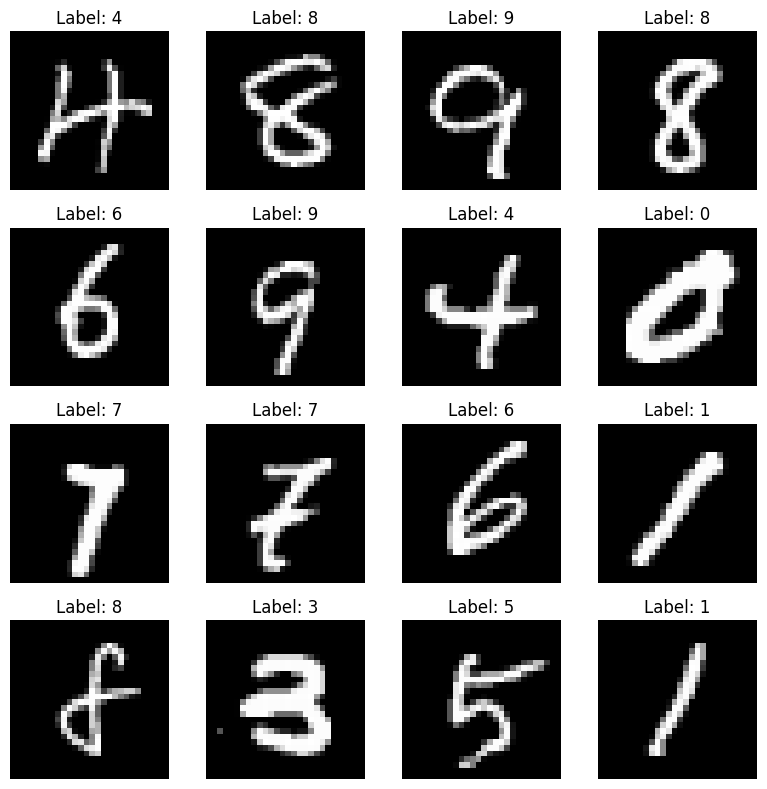

In [4]:
# visualize the MNIST dataset
# create an iterator over the DataLoader
data_iter = iter(train_loader)
# get the next batch of images and labels
images, labels = next(data_iter)

# visualize the images in a 4x4 grid
plt.figure(figsize=(8, 8))

# loop over the first 16 images
for i in range(16):
    # create a subplot for each image
    plt.subplot(4, 4, i + 1)
    # display the image in grayscale
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# define the artificial neural network model
# create a simple 2-layer fully-connected network with ReLU activation
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.flatten = nn.Flatten()
        # 1st fully-connected layer
        self.fc1 = nn.Linear(28 * 28, 10)
        # 2nd fully-connected layer
        self.fc2 = nn.Linear(10, 10)

    # define the forward pass
    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# instantiate the model
model = ANN().to(device)

# number of epochs
epochs = 10
# use CrossEntropyLoss and Adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# initialize lists to store loss and accuracy
train_losses_ann = []
test_losses_ann = []
test_accuracies_ann = []

In [7]:
# train the model in a single epoch
def train_ann(model, train_loader, criterion, optimizer, epoch):
    # set the model to training mode
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        # clear the gradients
        optimizer.zero_grad()
        # move data to current device
        data, target = data.to(device), target.to(device)
        output = model(data)
        # compute loss
        loss = criterion(output, target)
        loss.backward()
        # update the weights
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)} / {len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    # compute average loss in each epoch
    average_loss = running_loss / len(train_loader)
    return average_loss

# test the model in a single epoch
def test_ann(model, test_loader, criterion):
    # set the model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0

    # disable gradient calculation
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += criterion(output, target).item()
            # get the index of the max output as the predicted category
            pred = output.argmax(dim=1, keepdim=True)
            # compute correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # average test loss
    test_loss /= len(test_loader.dataset)
    # test accuracy
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'-> Test: Average loss: {test_loss:.4f}, Accuracy: {correct} / {len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return accuracy, test_loss

In [8]:
# train and test the model
for epoch in range(epochs):
    average_loss = train_ann(model, train_loader, criterion, optimizer, epoch)
    train_losses_ann.append(average_loss)
    accuracy, test_loss = test_ann(model, test_loader, criterion)
    test_losses_ann.append(test_loss)
    test_accuracies_ann.append(accuracy)

Train Epoch: 0 [0 / 60000 (0%)]	Loss: 2.344866
Train Epoch: 0 [6400 / 60000 (11%)]	Loss: 1.087901
Train Epoch: 0 [12800 / 60000 (21%)]	Loss: 0.874441
Train Epoch: 0 [19200 / 60000 (32%)]	Loss: 0.426781
Train Epoch: 0 [25600 / 60000 (43%)]	Loss: 0.431575
Train Epoch: 0 [32000 / 60000 (53%)]	Loss: 0.547910
Train Epoch: 0 [38400 / 60000 (64%)]	Loss: 0.468825
Train Epoch: 0 [44800 / 60000 (75%)]	Loss: 0.584116
Train Epoch: 0 [51200 / 60000 (85%)]	Loss: 0.337336
Train Epoch: 0 [57600 / 60000 (96%)]	Loss: 0.234641
-> Test: Average loss: 0.0033, Accuracy: 9127 / 10000 (91%)

Train Epoch: 1 [0 / 60000 (0%)]	Loss: 0.241819
Train Epoch: 1 [6400 / 60000 (11%)]	Loss: 0.121309
Train Epoch: 1 [12800 / 60000 (21%)]	Loss: 0.383527
Train Epoch: 1 [19200 / 60000 (32%)]	Loss: 0.308471
Train Epoch: 1 [25600 / 60000 (43%)]	Loss: 0.303564
Train Epoch: 1 [32000 / 60000 (53%)]	Loss: 0.329360
Train Epoch: 1 [38400 / 60000 (64%)]	Loss: 0.233107
Train Epoch: 1 [44800 / 60000 (75%)]	Loss: 0.419102
Train Epoch: 1 

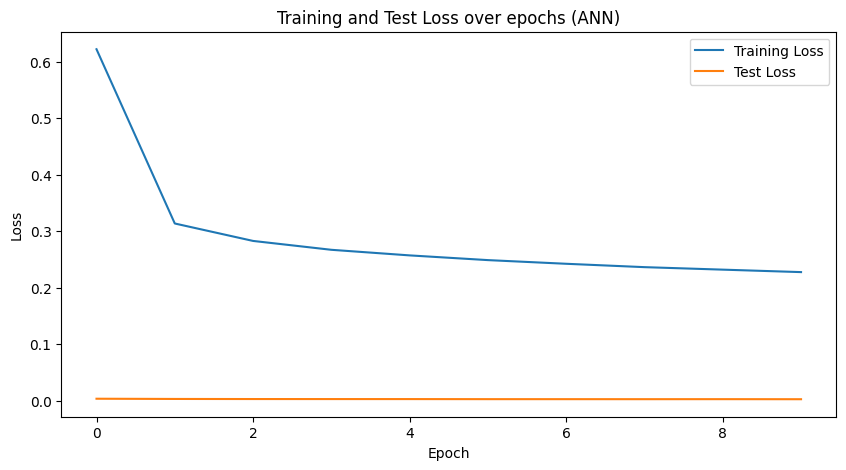

In [9]:
# plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses_ann, label='Training Loss')
plt.plot(range(epochs), test_losses_ann, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over epochs (ANN)')
plt.legend()
plt.show()

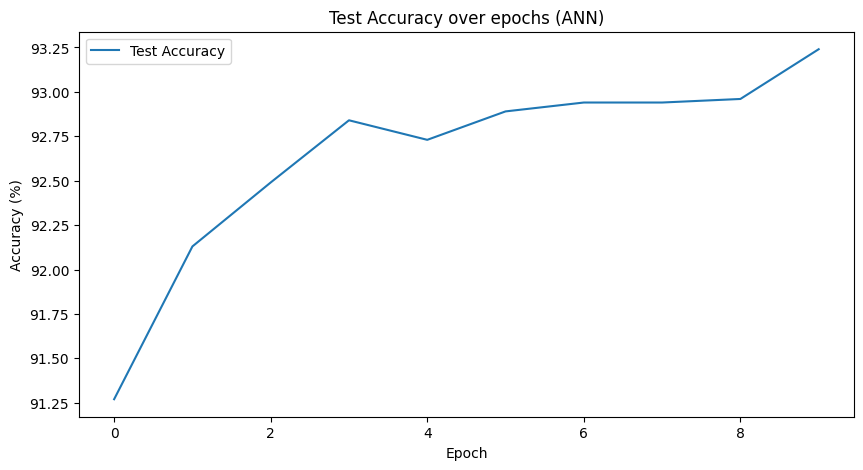

In [10]:
# plot testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), test_accuracies_ann, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over epochs (ANN)')
plt.legend()
plt.show()

### Part 2: Leaky Integrate and Fire (LIF) Spiking neurons

Let's install a useful package, snnTorch, which already has many spiking neuron implementations with surrogates handled in the backend.

In [11]:
!pip install snntorch

Leaky Integrate and Fire (LIF) neurons are one of the simplest neurons and are really easy to implement within the spiking domain.

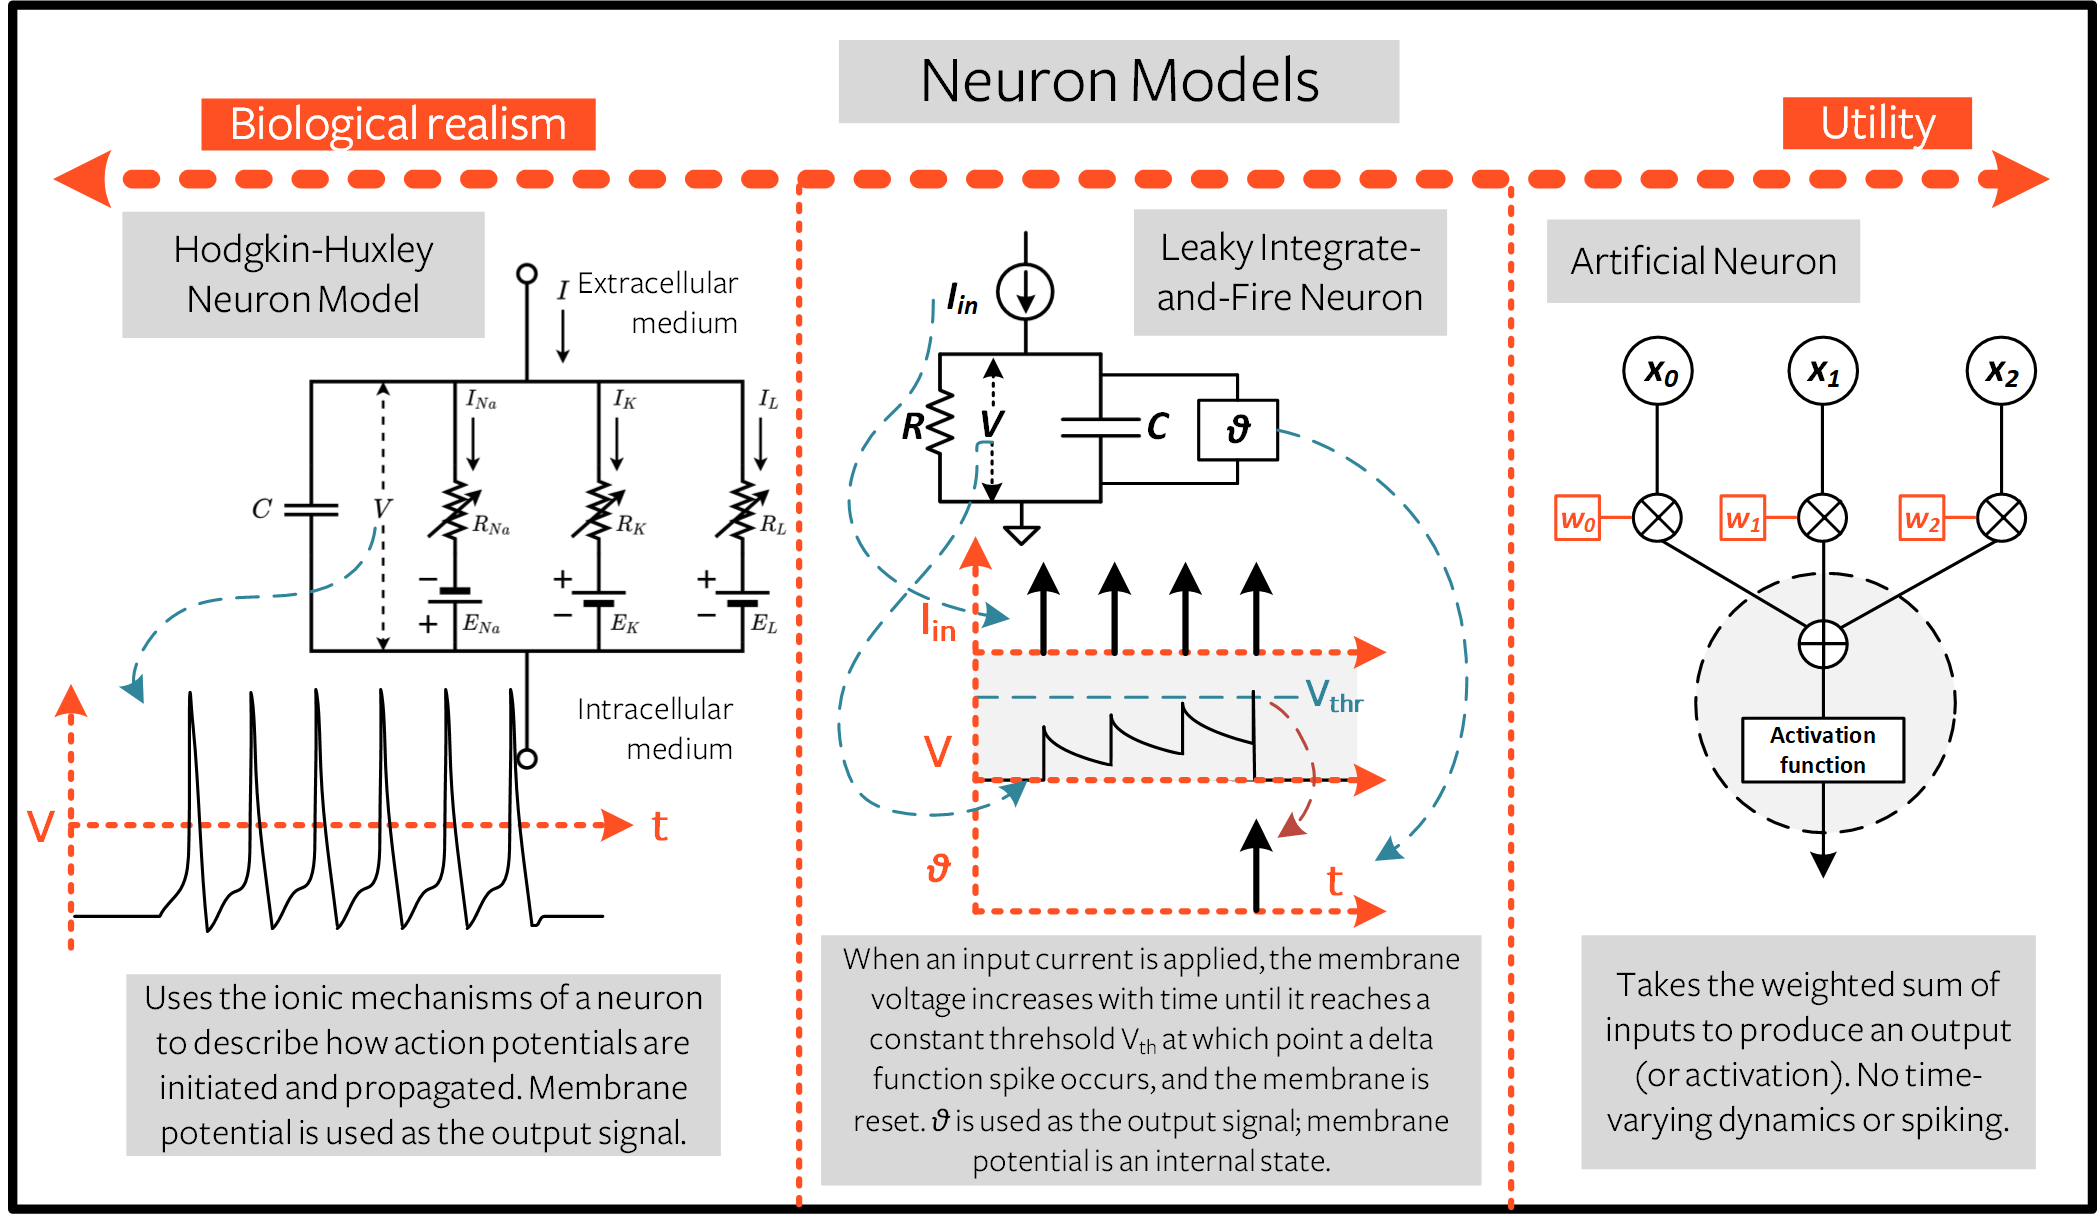

Below is the simplified hardware model of LIF neurons.

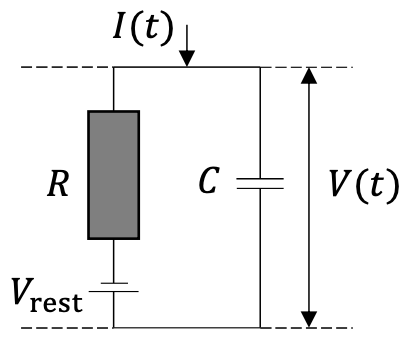

Components of the LIF model include:
- Resistor (R): The resistor controls how much the membrane potential leaks over time. The higher the resistance, the slower the leakage of the potential.
- Capacitor (C): It stores electrical charge, which represents the neuron's membrane potential $V_t$. The capacitor's voltage changes in response to the input current $I_t$. The change in the voltage of a capacitor is:
$$
C \frac{dV_t}{dt} = I_C
$$
- Input Current ($I_t$): This is the external input current that flows into the neuron, analogous to the synaptic input that a neuron would receive from other neurons.
- Resting Potential ($V_{rest}$): This is the membrane potential when the neuron is not receiving any input. In biology, it is usually set to a small negative value, representing the difference in ion concentration inside and outside the neuron. In our experiment, let's assume for the following sketch that the rest potential is $V_{rest}$ = 0.
- Membrane Potential ($V_t$): This represents the neuron's membrane potential at a given time. It changes according to the input current and the dynamics of the resistor and capacitor.

For a soft-reset LIF neuron, the update function is
$$
o_{t+1} = H(V_t - V_{th}) \\
V_{t+1} = \beta V_t + I_t - o_{t+1} \cdot V_{th}
$$
where $H$ is the Heaviside function, $o_t$ is output spike, $V_t$ is the membrane potential, $I_t$ is the external input current, $\beta$ is the leaky parameter, $V_{th}$ is the threshold.

Now let's import related packages first.

In [12]:
import snntorch as snn
import snntorch.spikeplot as splt
from IPython.display import HTML

#### Let's write our own implementation of LIF neuron using `PyTorch`.

In [13]:
class LeakyIntegrateFire(nn.Module):
    def __init__(self, beta, threshold=1.0):
        super(LeakyIntegrateFire, self).__init__()
        self.beta = beta
        self.threshold = threshold
        self.spike_op = self.SpikeOperator.apply
        self.mem = torch.zeros(1)

    # the forward function is called each time we call LeakyIntegrateFire
    def forward(self, input_):
        spk = self.spike_op(self.mem - self.threshold)  # call the Heaviside function
        reset = (spk * self.threshold).detach()  # removes spike_op gradient from reset
        # TODO: add your implementation here.
        self.mem = self.beta * self.mem + input_ - reset
        return spk

    # forward pass: Heaviside function
    @staticmethod
    class SpikeOperator(torch.autograd.Function):
        @staticmethod
        def forward(ctx, input):
            spk = torch.zeros_like(input)
            spk[input > 0] = 1
            ctx.save_for_backward(spk)
            return spk

#### Simulation of LeakyIntegrateFire over 200 time steps

Text(0.5, 0, 'Time')

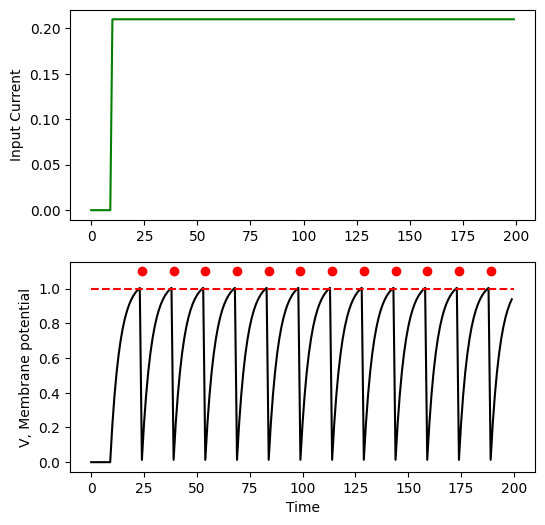

In [14]:
num_steps = 200

lif = LeakyIntegrateFire(beta=0.8)
# Small step current input
w = 0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190) * w), 0)
mem_rec = []
spk_rec = []

for step in range(num_steps):
    spk = lif(cur_in[step])
    mem_rec.append(lif.mem)
    spk_rec.append(spk)

mem_rec = torch.stack(mem_rec).numpy()
spk_rec = torch.stack(spk_rec).numpy()

plt.figure(figsize=[6, 6])
plt.subplot(211)
plt.plot(cur_in, 'g')
plt.ylabel('Input Current')
plt.subplot(212)
plt.plot(mem_rec, 'k')
plt.scatter(np.where(spk_rec > 0)[0], 1.1 * np.ones([np.sum(spk_rec > 0), 1]), c='r')
plt.plot([0, num_steps], [1, 1], '--r')
plt.ylabel('V, Membrane potential')
plt.xlabel('Time')

#### Let's simulate the LIF neuron using snnTorch by directly calling `snn.Leaky` API.

Text(0.5, 0, 'Time')

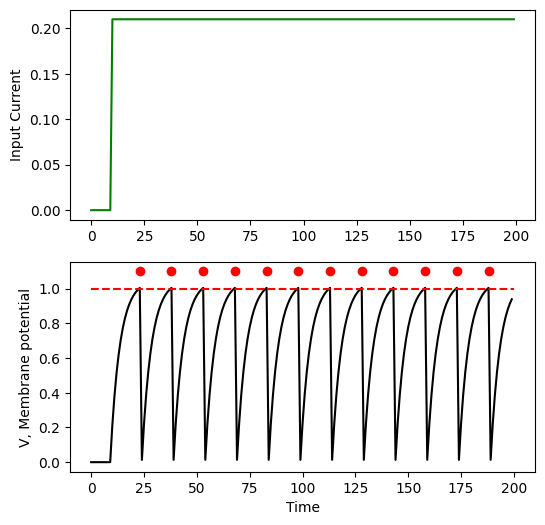

In [15]:
# Leaky membrane simulation
num_steps = 200

# snntorch API for LIF neuron, where beta is membrane potential decay rate
# reset_mechanism defaults to subtract (soft-reset).
lif = snn.Leaky(beta=0.8, reset_mechanism="subtract")
w = 0.21
# input current
cur_in = torch.cat((torch.zeros(10), torch.ones(190) * w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

for step in range(num_steps):
    # update membrane potential and output spike
    spk, mem = lif(cur_in[step], mem)
    mem_rec.append(mem)
    spk_rec.append(spk)

mem_rec = torch.stack(mem_rec).numpy()
spk_rec = torch.stack(spk_rec).numpy()

plt.figure(figsize=[6, 6])
plt.subplot(211)
plt.plot(cur_in, 'g')
plt.ylabel('Input Current')
plt.subplot(212)
plt.plot(mem_rec, 'k')
plt.scatter(np.where(spk_rec > 0)[0], 1.1 * np.ones([np.sum(spk_rec > 0), 1]), c='r')
plt.plot([0, num_steps], [1, 1], '--r')
plt.ylabel('V, Membrane potential')
plt.xlabel('Time')

The plots look exactly the same!

#### Explore the connection between firing rate and stimulus amplitude

The rate encoding hypothesis suggests that neurons can encode continous value quantities in their discrete spikes by modulating the spiking rate. Let's plot up firing rate versus fixed stimulus amplitude.

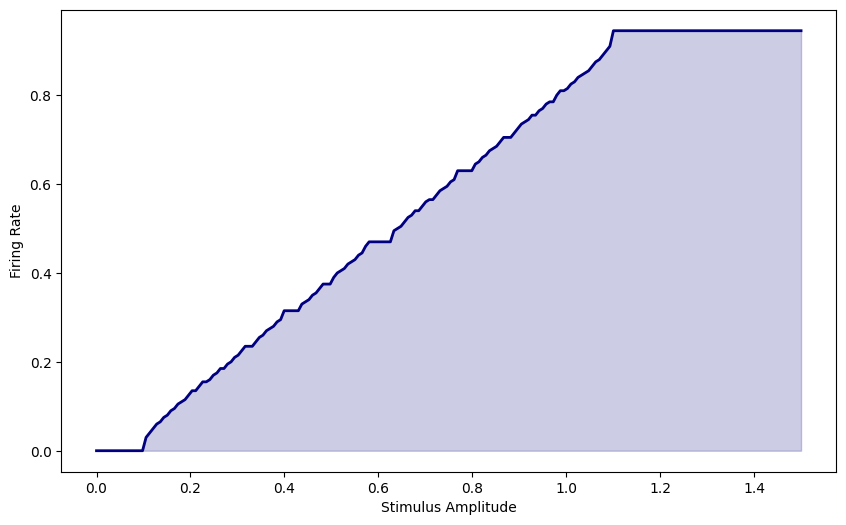

In [16]:
import matplotlib.cm as cm

def get_number_of_spikes(inputmag, beta=0.8, num_steps=200):
    lif = LeakyIntegrateFire(beta=beta)
    cur_in = torch.cat((torch.zeros(10), torch.ones(num_steps - 10) * inputmag), 0)
    mem = torch.zeros(1)
    spk = torch.zeros(1)
    mem_rec = []
    spk_rec = []
    for step in range(num_steps):
        spk = lif(cur_in[step])
        mem_rec.append(lif.mem)
        spk_rec.append(spk)
    mem_rec = torch.stack(mem_rec).numpy()
    spk_rec = torch.stack(spk_rec).numpy()
    return np.sum(spk_rec > 0) / num_steps

num_beta = 1
inputs_to_study = np.linspace(0, 1.5, 200)
betas = np.array([0.9])
spike_count = np.zeros((inputs_to_study.shape[0], betas.shape[0]))
for i, input in enumerate(inputs_to_study):
  for j, beta in enumerate(betas):
    spike_count[i, j] = get_number_of_spikes(input, beta=beta)

cmap = cm.jet(np.linspace(0, 1, num_beta))
plt.figure(figsize=[10, 6])
for k in range(num_beta):
    plt.plot(inputs_to_study, spike_count[:, k], color=cmap[k, :], lw=2)
    plt.fill_between(inputs_to_study, 0 * spike_count[:, k], spike_count[:, k], color=cmap[k,:], alpha=0.2)
plt.ylabel('Firing Rate')
plt.xlabel('Stimulus Amplitude')
plt.show()

### Part 3: Train a Spiking Neural Network with LIF using true gradient and surrogate gradient descent

#### Define true gradient backprop in LIF neuron by scaling the gradient with the spike response

In [17]:
class LeakyTrue(nn.Module):
    def __init__(self, beta, threshold=1.0):
        super(LeakyTrue, self).__init__()

        # initialize decay rate beta and threshold
        self.beta = beta
        self.threshold = threshold
        self.spike_op = self.SpikeOperator.apply
        self.mem = None

    # the forward function is called each time we call LeakyTrue
    def forward(self, input_):
        spk = self.spike_op(self.mem - self.threshold)  # call the Heaviside function
        reset = (spk * self.threshold).detach() # removes spike_op gradient from reset
        self.mem = self.beta * self.mem + input_ - reset
        return spk

    # forward pass: Heaviside function
    @staticmethod
    class SpikeOperator(torch.autograd.Function):
        @staticmethod
        def forward(ctx, input):
            spk = torch.zeros_like(input)
            spk[input > 0] = 1.0
            ctx.save_for_backward(spk)
            return spk

        @staticmethod
        def backward(ctx, grad_output):
            spk, = ctx.saved_tensors
            # TODO: add your implementation here.
            grad = grad_output * spk
            return grad, None

#### Generate input data for SNN

There are several ways to generate input data.
- **Mode 1**: Repeatedly pass the same original training sample to the network at each time step. This is like converting MNIST into a static, unchanging video.
- Convert the input into a binary spike train of sequence length, where each pixel takes on a discrete value $\{0,1\}$.
  - **Mode 2**: Compare each pixel to a fixed threshold and repeatedly pass the same input to the network at each time step.
  - **Mode 3**: Each input feature is used as the probability an event (spike) occurs at any given time step, returning a rate-coded value. This can be treated as a Bernoulli trial.

In [18]:
# mode 1: repeatedly pass the same original training sample to the network
def gen_train_data_img(x, T=50):
    res = []
    for t in range(T):
        res.append(x)
    return torch.stack(res)

# mode 2: compare each pixel to a fixed threshold and repeatedly pass the same input to the network
def threshold_encoder(x, threshold=0.5):
    # insert your code here
    x[x < threshold] = 0
    return x

def gen_spike_data_static(x, T=50):
    res = []
    for t in range(T):
        encoded_img = threshold_encoder(x)
        res.append(encoded_img)
    return torch.stack(res)

# mode 3: each input feature is used as the probability a spike occurs at any given time step
def gen_spike_data_bernoulli(x, T=50):
    res = []
    for t in range(T):
        # TODO: add your implementation here.
        encoded_img = torch.bernoulli(x)
        res.append(encoded_img)
    return torch.stack(res)

torch.Size([50, 28, 28])


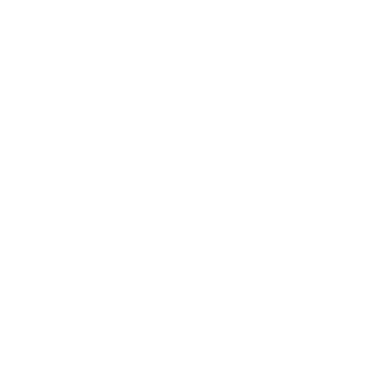

In [19]:
test_visualization_img = images[2][0]

generated_spike_train = gen_spike_data_static(test_visualization_img)
print(generated_spike_train.shape)

fig, ax = plt.subplots()
anim = splt.animator(generated_spike_train, fig, ax)

HTML(anim.to_html5_video())

#### Design a Spiking Neural Network

One simple implementation of SNN is to replace ReLU activation in ANN with LIF neurons.

In [20]:
# define the spiking neural network model
class SNNTrueGradient(nn.Module):
    def __init__(self, T, beta=0.8):
        super(SNNTrueGradient, self).__init__()
        self.T = T
        self.flatten = nn.Flatten()
        # 1st fully-connected layer
        self.fc1 = nn.Linear(28 * 28, 10)
        self.lif1 = LeakyTrue(beta=beta) # replace ReLU as an activation in SNN
        # 2nd fully-connected layer
        self.fc2 = nn.Linear(10, 10)
        # output layer neurons, whose firing rate will be served as the final prediction
        self.lif2 = LeakyTrue(beta=beta)

    def init_mem(self, batch_size, feature_num):
        return nn.init.kaiming_uniform_(torch.empty(batch_size, feature_num)).to(device)

    # define the forward pass
    def forward(self, input_):
        # input size: [T, batch_size, 28*28]
        self.lif1.mem = self.init_mem(input_.shape[1], 10)
        self.lif2.mem = self.init_mem(input_.shape[1], 10)

        output_spikes = torch.zeros(input_.shape[1], 10).to(device)
        for t in range(self.T):
            x = input_[t]
            x = self.flatten(x)
            x = self.fc1(x)
            spk1 = self.lif1(x)
            x = self.fc2(spk1)
            spk2 = self.lif2(x)
            # TODO: add your implementation here.
            output_spikes += spk2

        # TODO: add your implementation here.
        return output_spikes / self.T

#### Define training and testing function

In [25]:
def train_snn(model, train_loader, criterion, optimizer, epoch, T=50):
    # set the model to training mode
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        # clear the gradients
        optimizer.zero_grad()
        # move data to GPU
        data, target = data.to(device), target.to(device)
        target_onehot = F.one_hot(target, 10).float()
        output_fr = model(gen_spike_data_bernoulli(data, T))
        # compute the loss
        loss = criterion(output_fr, target_onehot)
        loss.backward()
        # update the weights
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)} / {len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    # compute average loss in each epoch
    average_loss = running_loss / len(train_loader)
    return average_loss

In [26]:
def test_snn(model, test_loader, criterion, T=50):
    # set the model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0

    # disable gradient calculation
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target_onehot = F.one_hot(target, 10).float()
            output_fr = model(gen_spike_data_bernoulli(data, T))
            # sum up batch loss
            test_loss += criterion(output_fr, target_onehot).item()
            # get the index of the max log-probability as the predicted category
            pred = output_fr.argmax(dim=1, keepdim=True)
            # compute correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # average test loss
    test_loss /= len(test_loader.dataset)
    # accuracy percentage
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'-> Test: Average loss: {test_loss:.4f}, Accuracy: {correct} / {len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return accuracy, test_loss

#### Train the SNN model and visualize the results with true gradient

In [27]:
# instantiate the model
T = 5
model = SNNTrueGradient(T).to(device)

# define the number of epochs, loss function and optimizer
# use MSELoss and Adam optimizer
epochs = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# initialize lists to store loss and accuracy
train_losses_snn_true_gradient = []
test_losses_snn_true_gradient = []
test_accuracies_snn_true_gradient = []

In [28]:
# train and test the model
for epoch in range(epochs):
    train_loss = train_snn(model, train_loader, criterion, optimizer, epoch, T)
    train_losses_snn_true_gradient.append(train_loss)
    accuracy, test_loss = test_snn(model, test_loader, criterion, T)
    test_losses_snn_true_gradient.append(test_loss)
    test_accuracies_snn_true_gradient.append(accuracy)

Train Epoch: 0 [0 / 60000 (0%)]	Loss: 0.100437
Train Epoch: 0 [6400 / 60000 (11%)]	Loss: 0.097500
Train Epoch: 0 [12800 / 60000 (21%)]	Loss: 0.096813
Train Epoch: 0 [19200 / 60000 (32%)]	Loss: 0.096625
Train Epoch: 0 [25600 / 60000 (43%)]	Loss: 0.095812
Train Epoch: 0 [32000 / 60000 (53%)]	Loss: 0.094000
Train Epoch: 0 [38400 / 60000 (64%)]	Loss: 0.099688
Train Epoch: 0 [44800 / 60000 (75%)]	Loss: 0.097687
Train Epoch: 0 [51200 / 60000 (85%)]	Loss: 0.097125
Train Epoch: 0 [57600 / 60000 (96%)]	Loss: 0.092062
-> Test: Average loss: 0.0010, Accuracy: 980 / 10000 (10%)

Train Epoch: 1 [0 / 60000 (0%)]	Loss: 0.097562
Train Epoch: 1 [6400 / 60000 (11%)]	Loss: 0.098375
Train Epoch: 1 [12800 / 60000 (21%)]	Loss: 0.099625
Train Epoch: 1 [19200 / 60000 (32%)]	Loss: 0.097687
Train Epoch: 1 [25600 / 60000 (43%)]	Loss: 0.099625
Train Epoch: 1 [32000 / 60000 (53%)]	Loss: 0.098500
Train Epoch: 1 [38400 / 60000 (64%)]	Loss: 0.097500
Train Epoch: 1 [44800 / 60000 (75%)]	Loss: 0.095750
Train Epoch: 1 [

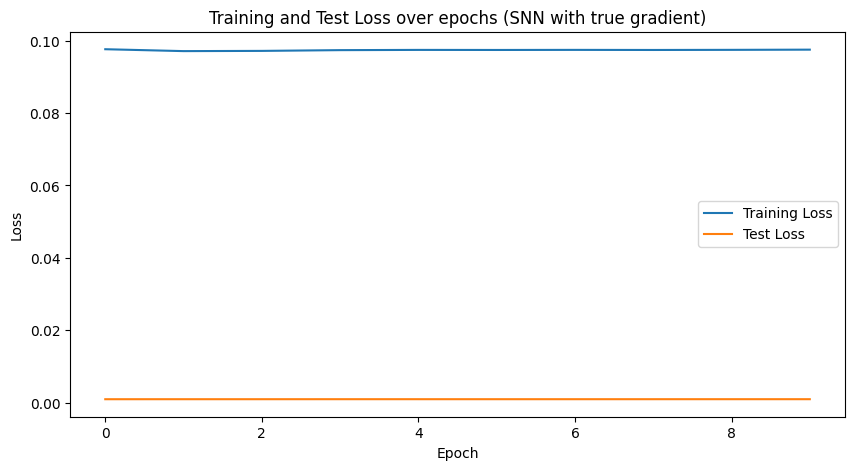

In [29]:
# plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses_snn_true_gradient, label='Training Loss')
plt.plot(range(epochs), test_losses_snn_true_gradient, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over epochs (SNN with true gradient)')
plt.legend()
plt.show()

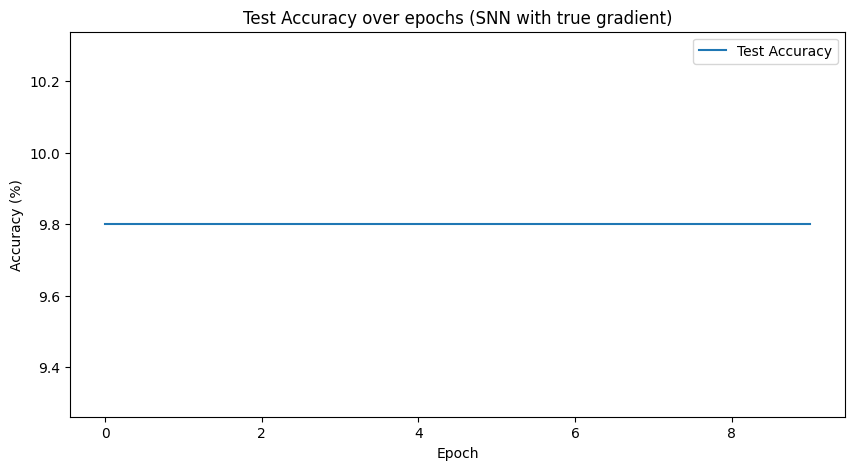

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), test_accuracies_snn_true_gradient, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over epochs (SNN with true gradient)')
plt.legend()
plt.show()

#### Utilize surrogate gradient descent for training a SNN

The core concept of surrogate gradient descent is to replace the discontinous spiking dynamics with a continous approximation. This has the effect of stretching the gradient information away from the binary presence or absence of a spike to something which carries a lot more information.

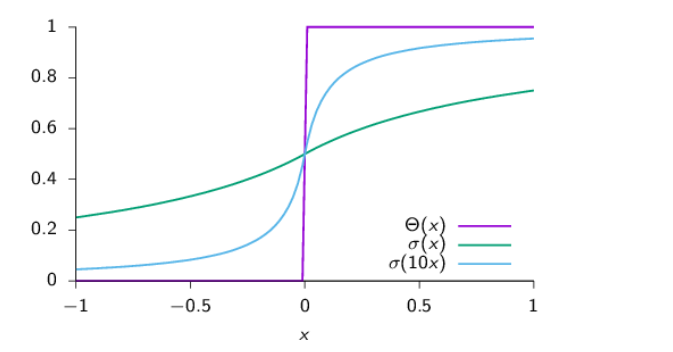

A commonly used approach is replacing the Heaviside function with a fast sigmoid function

$$
\sigma(x) = \frac{1}{1 + e^{-z x}}
$$

where $z$ controls the sharpness of this surrogage.

Let's implement this in pytorch.

In [31]:
class LeakySurrogate(nn.Module):
    def __init__(self, beta, z=1, threshold=1.0):
        super(LeakySurrogate, self).__init__()

        # initialize decay rate beta and threshold
        self.beta = beta
        self.threshold = threshold
        self.spike_op = self.SpikeOperator.apply
        self.z = z
        self.mem = None

    # the forward function is called each time we call Leaky
    def forward(self, input_):
        spk = self.spike_op(self.mem - self.threshold, self.z)  # call the Heaviside function
        reset = (spk * self.threshold).detach() # removes spike_op gradient from reset
        self.mem = self.beta * self.mem + input_ - reset
        return spk

    # forward pass: Heaviside function
    @staticmethod
    class SpikeOperator(torch.autograd.Function):
        @staticmethod
        def forward(ctx, input, z):
            """
            In the forward pass we compute a step function of the input Tensor
            and return it. ctx is a context object that we use to stash information which
            we need to later backpropagate our error signals. To achieve this we use the
            ctx.save_for_backward method.
            """
            ctx.save_for_backward(input)
            ctx.z = z
            spk = torch.zeros_like(input)
            spk[input > 0] = 1.0
            return spk

        @staticmethod
        def backward(ctx, grad_output):
            """
            In the backward pass we receive a Tensor we need to compute the
            surrogate gradient of the loss with respect to the input.
            Here we use the fast Sigmoid function with z = 1.
            """
            input, = ctx.saved_tensors
            z = ctx.z
            grad_input = grad_output.clone()
            # TODO: add your implementation here.
            grad = grad_input * z * torch.exp(-z * input) / (1 + torch.exp(-z * input)) ** 2
            return grad, None

#### Train the SNN using surrogate gradient descent and visualize the results

In [32]:
class SNN(nn.Module):
    def __init__(self, T, beta=0.8, z=1, threshold=1.0):
        super(SNN, self).__init__()
        self.T = T
        self.flatten = nn.Flatten()
        # 1st fully-connected layer
        self.fc1 = nn.Linear(28 * 28, 10)
        self.lif1 = LeakySurrogate(beta=beta, z=z, threshold=threshold)
        # 2nd fully-connected layer
        self.fc2 = nn.Linear(10, 10)
        # output layer neurons, whose firing rate will be served as the final prediction
        self.lif2 = LeakySurrogate(beta=beta, z=z, threshold=threshold)

    def init_mem(self, batch_size, feature_num):
        return nn.init.kaiming_uniform_(torch.empty(batch_size, feature_num)).to(device)

    # define the forward pass
    def forward(self, input_):
        # input size: [T, batch_size, 28, 28]

        self.lif1.mem = self.init_mem(input_.shape[1], 10)
        self.lif2.mem = self.init_mem(input_.shape[1], 10)

        output_spikes = 0
        for t in range(self.T):
            x = input_[t] # input size: [batch_size, 28, 28]
            x = self.flatten(x) # input size: [batch_size, 28*28]
            x = self.fc1(x) # input size: [batch_size, 10]
            spk1 = self.lif1(x) # input size: [batch_size, 10]
            x = self.fc2(spk1) # input size: [batch_size, 10]
            spk2 = self.lif2(x) # input size: [batch_size, 10]
            output_spikes = output_spikes + spk2

        return output_spikes / self.T

In [33]:
# instantiate the model
T = 5
model = SNN(T).to(device)

epochs = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
# initialize lists to store loss and accuracy
train_losses_snn = []
test_losses_snn = []
test_accuracies_snn = []

# train and test the model
for epoch in range(epochs):
    train_loss = train_snn(model, train_loader, criterion, optimizer, epoch, T)
    train_losses_snn.append(train_loss)
    accuracy, test_loss = test_snn(model, test_loader, criterion, T)
    test_losses_snn.append(test_loss)
    test_accuracies_snn.append(accuracy)

Train Epoch: 0 [0 / 60000 (0%)]	Loss: 0.100375
Train Epoch: 0 [6400 / 60000 (11%)]	Loss: 0.089500
Train Epoch: 0 [12800 / 60000 (21%)]	Loss: 0.068875
Train Epoch: 0 [19200 / 60000 (32%)]	Loss: 0.056375
Train Epoch: 0 [25600 / 60000 (43%)]	Loss: 0.053812
Train Epoch: 0 [32000 / 60000 (53%)]	Loss: 0.046125
Train Epoch: 0 [38400 / 60000 (64%)]	Loss: 0.041813
Train Epoch: 0 [44800 / 60000 (75%)]	Loss: 0.045750
Train Epoch: 0 [51200 / 60000 (85%)]	Loss: 0.038250
Train Epoch: 0 [57600 / 60000 (96%)]	Loss: 0.039062
-> Test: Average loss: 0.0004, Accuracy: 8281 / 10000 (83%)

Train Epoch: 1 [0 / 60000 (0%)]	Loss: 0.038125
Train Epoch: 1 [6400 / 60000 (11%)]	Loss: 0.035625
Train Epoch: 1 [12800 / 60000 (21%)]	Loss: 0.033062
Train Epoch: 1 [19200 / 60000 (32%)]	Loss: 0.031125
Train Epoch: 1 [25600 / 60000 (43%)]	Loss: 0.035625
Train Epoch: 1 [32000 / 60000 (53%)]	Loss: 0.031875
Train Epoch: 1 [38400 / 60000 (64%)]	Loss: 0.037813
Train Epoch: 1 [44800 / 60000 (75%)]	Loss: 0.039812
Train Epoch: 1 

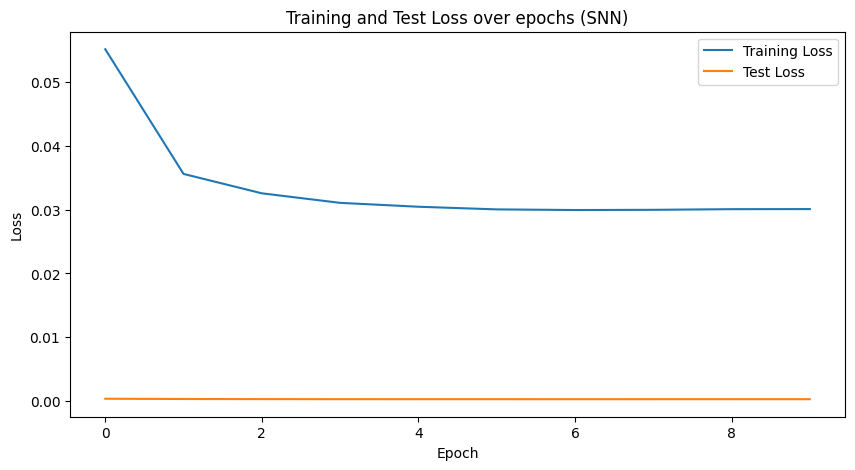

In [35]:
# plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses_snn, label='Training Loss')
plt.plot(range(epochs), test_losses_snn, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over epochs (SNN)')
plt.legend()
plt.show()

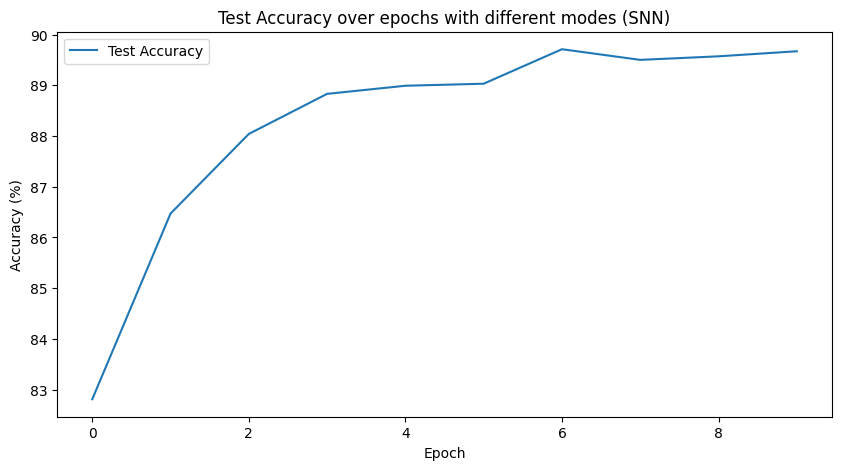

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), test_accuracies_snn, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over epochs with different modes (SNN)')
plt.legend()
plt.show()

#### Compare performance of SNN with ANN

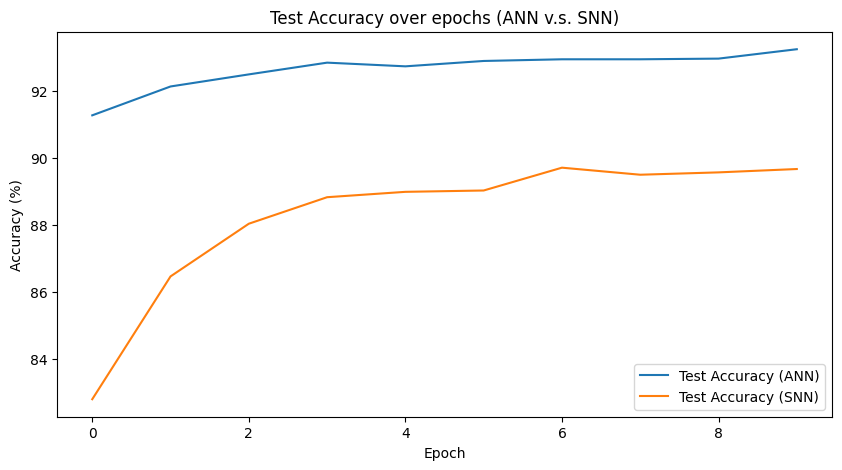

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), test_accuracies_ann, label='Test Accuracy (ANN)')
plt.plot(range(epochs), test_accuracies_snn, label='Test Accuracy (SNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over epochs (ANN v.s. SNN)')
plt.legend()
plt.show()

### Part 4: After-class questions

**Report section guideline**:
For each sub-section, briefly introduce your design ideas and findings in the report.

**Additional analysis (1 extra point)**: Try to investigate the differences between ANN and SNN at a high level, including but not limited to:
- Examine the efficiency of ANN and SNN in terms of training and inference time.
- Compare learning dynamics of ANN and SNN. Focus on aspects such as convergence rate and stability during training.

#### 4.1 Hyperparameter tuning (10 points)

Adjust various hyperparameters within the network to observe and analyze their impact on performance. Specific parameters of interest include:
- $z$ in fast Sigmoid activation function
- Leaky rate $\beta$ in LIF neurons
- Neuron threshold $V_{th}$
- Time steps $T$

Additionally, explore various methods of generating input data to determine how changes in input characteristics affect network output.

Critical steps:
- **Reinitialize the Optimizer**: It is crucial to reinitialize the optimizer before conducting each new experiment to ensure that results are not biased by previous configurations.
- **Data Recording and Analysis**: Plot the ***test accuracies*** across epochs for each experimental setup.

Analatical focus:
- Reflect on whether there is a consistent relationship between the magnitude of parameter values and network performance. Does increasing or decreasing a parameter enhance or degrade the model's effectiveness?

#### 4.1.1 Hyperparameter tuning in $z$ in fast Sigmoid (2 points)

In [38]:
def train_varying_hyperparameters(z=1, beta=0.8, v_th=1.0, t=5):
    model = SNN(T=t, beta=beta, z=z, threshold=v_th).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses_snn = []
    test_losses_snn = []
    test_accuracies_snn = []
    epochs = 5

    for epoch in range(epochs):
        train_loss = train_snn(model, train_loader, criterion, optimizer, epoch, t)
        train_losses_snn.append(train_loss)
        accuracy, test_loss = test_snn(model, test_loader, criterion, t)
        test_losses_snn.append(test_loss)
        test_accuracies_snn.append(accuracy)

    return test_accuracies_snn

In [ ]:
# TODO: add your implementation here.
z_values = [0.1, 0.5, 1, 2, 5, 10]

test_accuracies_snn_varying_z = []
for z in z_values:
    test_accuracies_snn_varying_z.append(train_varying_hyperparameters(z=z))


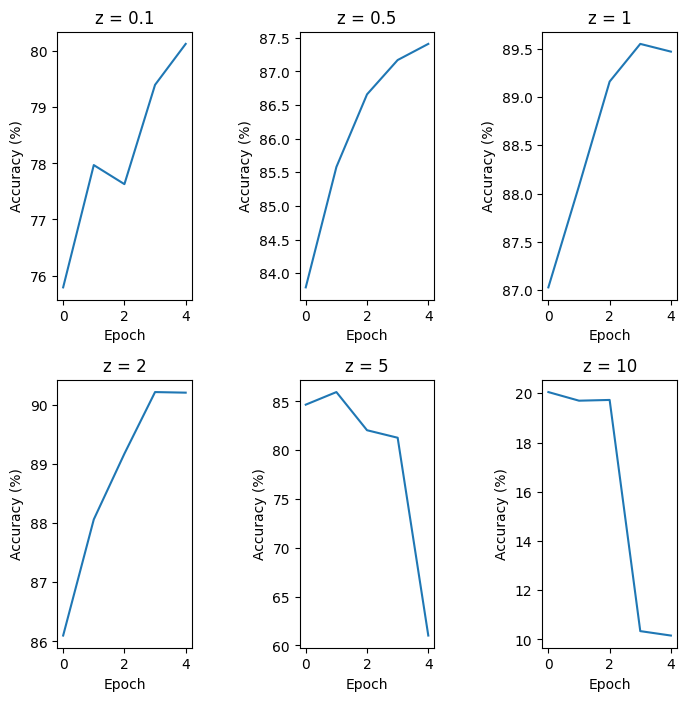

In [40]:
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
for r in range(2):
    for c in range(3):
        i = r * 3 + c
        z = z_values[i]
        axs[r][c].plot(range(len(test_accuracies_snn_varying_z[i])), test_accuracies_snn_varying_z[i])
        axs[r][c].set_title(f'z = {z}')
        axs[r][c].set_xlabel('Epoch')
        axs[r][c].set_ylabel('Accuracy (%)')

plt.subplots_adjust(wspace=0.8, hspace=0.3)

plt.show()

In [41]:
optimal_z = z_values[np.argmax([acc[-1] for acc in test_accuracies_snn_varying_z])]
optimal_z

2

#### 4.1.2 Hyperparameter tuning in $\beta$ (2 points)

In [ ]:
# TODO: add your implementation here.

beta_values = [0.1, 0.5, 0.8, 1, 2, 5]
test_accuracies_snn_varying_beta = []

for beta in beta_values:
    test_accuracies_snn_varying_beta.append(train_varying_hyperparameters(z=optimal_z, beta=beta))

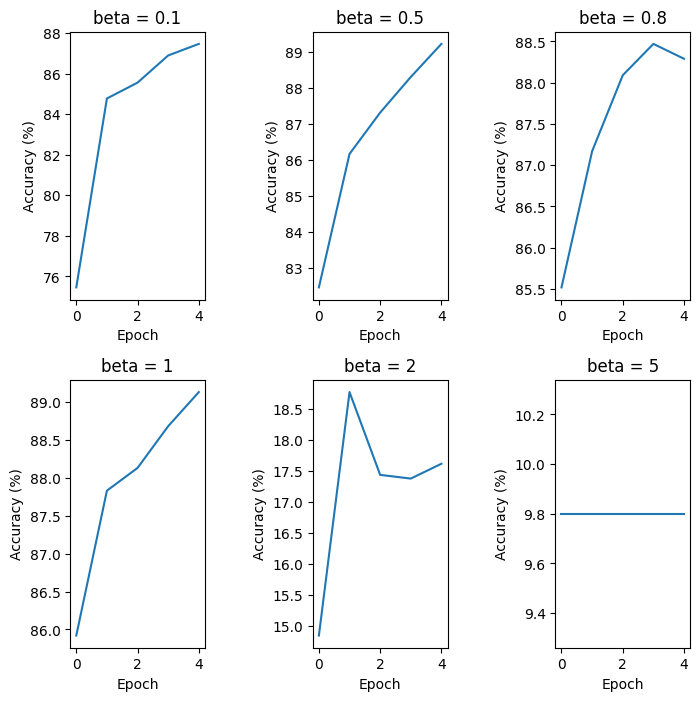

In [43]:
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
for r in range(2):
    for c in range(3):
        i = r * 3 + c
        beta = beta_values[i]
        axs[r][c].plot(range(len(test_accuracies_snn_varying_beta[i])), test_accuracies_snn_varying_beta[i])
        axs[r][c].set_title(f'beta = {beta}')
        axs[r][c].set_xlabel('Epoch')
        axs[r][c].set_ylabel('Accuracy (%)')


plt.subplots_adjust(wspace=0.8, hspace=0.3)
plt.show()

In [44]:
optimal_beta = beta_values[np.argmax([acc[-1] for acc in test_accuracies_snn_varying_beta])]
optimal_beta

0.5

#### 4.1.3 Hyperparameter tuning in neuron threshold $V_{th}$ (2 points)

In [45]:
# TODO: add your implementation here.
v_th_values = [0.1, 0.5, 1, 2, 5, 10]
test_accuracies_snn_varying_vth = []

for v_th in v_th_values:
    test_accuracies_snn_varying_vth.append(train_varying_hyperparameters(z=optimal_z, beta=optimal_beta, v_th=v_th))
    

Train Epoch: 0 [0 / 60000 (0%)]	Loss: 0.329125
Train Epoch: 0 [6400 / 60000 (11%)]	Loss: 0.107937
Train Epoch: 0 [12800 / 60000 (21%)]	Loss: 0.103188
Train Epoch: 0 [19200 / 60000 (32%)]	Loss: 0.088875
Train Epoch: 0 [25600 / 60000 (43%)]	Loss: 0.074312
Train Epoch: 0 [32000 / 60000 (53%)]	Loss: 0.072687
Train Epoch: 0 [38400 / 60000 (64%)]	Loss: 0.068687
Train Epoch: 0 [44800 / 60000 (75%)]	Loss: 0.059062
Train Epoch: 0 [51200 / 60000 (85%)]	Loss: 0.054437
Train Epoch: 0 [57600 / 60000 (96%)]	Loss: 0.053313
-> Test: Average loss: 0.0006, Accuracy: 7255 / 10000 (73%)

Train Epoch: 1 [0 / 60000 (0%)]	Loss: 0.063250
Train Epoch: 1 [6400 / 60000 (11%)]	Loss: 0.062437
Train Epoch: 1 [12800 / 60000 (21%)]	Loss: 0.057750
Train Epoch: 1 [19200 / 60000 (32%)]	Loss: 0.052000
Train Epoch: 1 [25600 / 60000 (43%)]	Loss: 0.058312
Train Epoch: 1 [32000 / 60000 (53%)]	Loss: 0.049812
Train Epoch: 1 [38400 / 60000 (64%)]	Loss: 0.057687
Train Epoch: 1 [44800 / 60000 (75%)]	Loss: 0.054625
Train Epoch: 1 

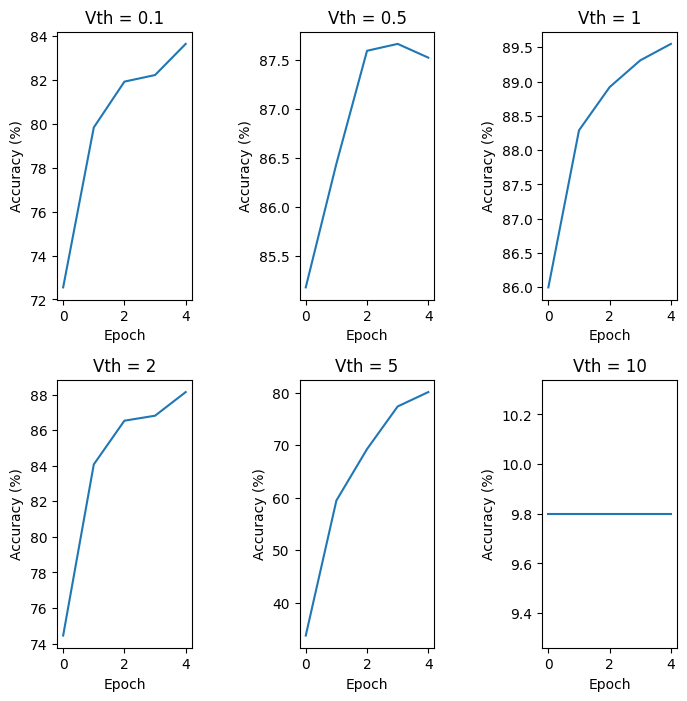

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
for r in range(2):
    for c in range(3):
        i = r * 3 + c
        v_th = v_th_values[i]
        axs[r][c].plot(range(len(test_accuracies_snn_varying_vth[i])), test_accuracies_snn_varying_vth[i])
        axs[r][c].set_title(f'Vth = {v_th}')
        axs[r][c].set_xlabel('Epoch')
        axs[r][c].set_ylabel('Accuracy (%)')
    
plt.subplots_adjust(wspace=0.8, hspace=0.3)
plt.show()

In [47]:
optimal_vth = v_th_values[np.argmax([acc[-1] for acc in test_accuracies_snn_varying_vth])]
optimal_vth

1

#### 4.1.4 Hyperparameter tuning in time steps $T$ (2 points)

In [48]:
# TODO: add your implementation here.

t_values = [2, 5, 10, 20, 50, 100]

test_accuracies_snn_varying_t = []

for t in t_values:
    test_accuracies_snn_varying_t.append(train_varying_hyperparameters(z=optimal_z, beta=optimal_beta, v_th=optimal_vth, t=t))

Train Epoch: 0 [0 / 60000 (0%)]	Loss: 0.100000
Train Epoch: 0 [6400 / 60000 (11%)]	Loss: 0.100000
Train Epoch: 0 [12800 / 60000 (21%)]	Loss: 0.100000
Train Epoch: 0 [19200 / 60000 (32%)]	Loss: 0.100000
Train Epoch: 0 [25600 / 60000 (43%)]	Loss: 0.100000
Train Epoch: 0 [32000 / 60000 (53%)]	Loss: 0.103516
Train Epoch: 0 [38400 / 60000 (64%)]	Loss: 0.112500
Train Epoch: 0 [44800 / 60000 (75%)]	Loss: 0.108984
Train Epoch: 0 [51200 / 60000 (85%)]	Loss: 0.112891
Train Epoch: 0 [57600 / 60000 (96%)]	Loss: 0.117188
-> Test: Average loss: 0.0013, Accuracy: 1033 / 10000 (10%)

Train Epoch: 1 [0 / 60000 (0%)]	Loss: 0.125000
Train Epoch: 1 [6400 / 60000 (11%)]	Loss: 0.130078
Train Epoch: 1 [12800 / 60000 (21%)]	Loss: 0.132422
Train Epoch: 1 [19200 / 60000 (32%)]	Loss: 0.119922
Train Epoch: 1 [25600 / 60000 (43%)]	Loss: 0.121875
Train Epoch: 1 [32000 / 60000 (53%)]	Loss: 0.127344
Train Epoch: 1 [38400 / 60000 (64%)]	Loss: 0.128516
Train Epoch: 1 [44800 / 60000 (75%)]	Loss: 0.123047
Train Epoch: 1 

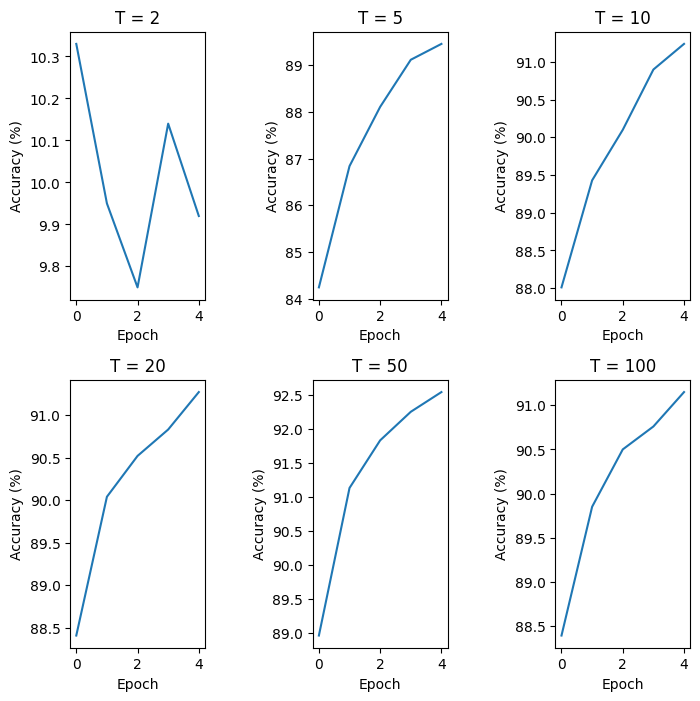

In [49]:
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
for r in range(2):
    for c in range(3):
        i = r * 3 + c
        t = t_values[i]
        axs[r][c].plot(range(len(test_accuracies_snn_varying_t[i])), test_accuracies_snn_varying_t[i])
        axs[r][c].set_title(f'T = {t}')
        axs[r][c].set_xlabel('Epoch')
        axs[r][c].set_ylabel('Accuracy (%)')

plt.subplots_adjust(wspace=0.8, hspace=0.3)
plt.show()

In [50]:
optimal_t = t_values[np.argmax([acc[-1] for acc in test_accuracies_snn_varying_t])]
optimal_t

50

#### 4.1.5 Different ways of generating input data (2 points)

To effectively evaluate the performance of different encoding strategies in your network, please use the following predefined functions and compare their outcomes:

Data Generation Functions:
- `gen_train_data_img()`: Utilize this function to generate image data for training the network.
- `gen_spike_data_static()`: Use this function to generate static spike data.

Compare the results obtained from the above methods with those generated by a Bernoulli encoder.

In [51]:
def train_snn_varied_data_gen(model, train_loader, criterion, optimizer, epoch, data_gen, T=50):
    # set the model to training mode
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        # clear the gradients
        optimizer.zero_grad()
        # move data to GPU
        data, target = data.to(device), target.to(device)
        target_onehot = F.one_hot(target, 10).float()
        output_fr = model(data_gen(data, T))
        # compute the loss
        loss = criterion(output_fr, target_onehot)
        loss.backward()
        # update the weights
        optimizer.step()
        running_loss += loss.item()

    # compute average loss in each epoch
    average_loss = running_loss / len(train_loader)
    return average_loss

def test_snn_varied_data_gen(model, test_loader, criterion, data_gen, T=50):
    # set the model to evaluation
    model.eval()
    test_loss = 0
    correct = 0

    # disable gradient calculation
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target_onehot = F.one_hot(target, 10).float()
            output_fr = model(data_gen(data, T))
            # sum up batch loss
            test_loss += criterion(output_fr, target_onehot).item()
            # get the index of the max log-probability as the predicted category
            pred = output_fr.argmax(dim=1, keepdim=True)
            # compute correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # average test loss
    test_loss /= len(test_loader.dataset)
    # accuracy percentage
    accuracy = 100. * correct / len(test_loader.dataset)

    return accuracy, test_loss

def train_with_data_gen(z=1, beta=0.8, v_th=1.0, t=5, data_gen=gen_spike_data_bernoulli, epochs=10):
    model = SNN(T=t, beta=beta, z=z, threshold=v_th).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses_snn = []
    test_losses_snn = []
    test_accuracies_snn = []

    for epoch in range(epochs):
        train_loss = train_snn_varied_data_gen(model, train_loader, criterion, optimizer, epoch, data_gen, t)
        train_losses_snn.append(train_loss)
        accuracy, test_loss = test_snn_varied_data_gen(model, test_loader, criterion, data_gen, t)
        test_losses_snn.append(test_loss)
        test_accuracies_snn.append(accuracy)

    return test_accuracies_snn

In [52]:
train_data_img_test_accuracy = train_with_data_gen(z=optimal_z, beta=optimal_beta, v_th=optimal_vth, t=optimal_t, data_gen=gen_train_data_img)
train_spike_data_static_test_accuracy = train_with_data_gen(z=optimal_z, beta=optimal_beta, v_th=optimal_vth, t=optimal_t, data_gen=gen_spike_data_static)
train_bernoulli_test_accuracy = train_with_data_gen(z=optimal_z, beta=optimal_beta, v_th=optimal_vth, t=optimal_t, data_gen=gen_spike_data_bernoulli)

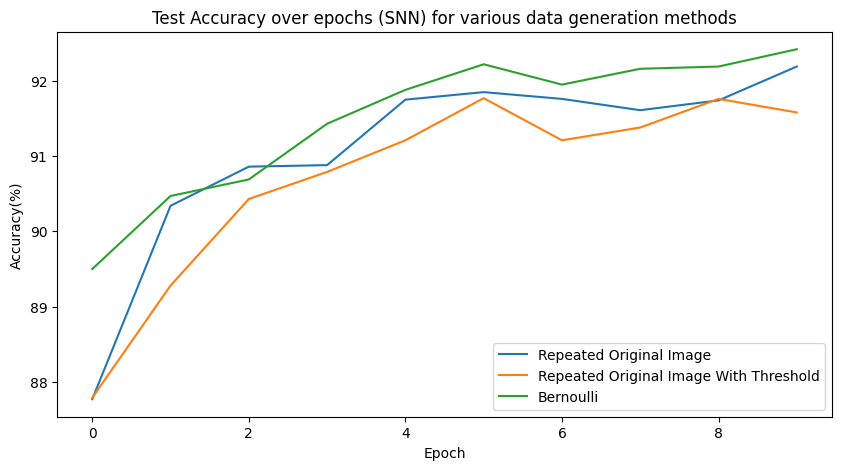

In [53]:
# plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_data_img_test_accuracy, label='Repeated Original Image')
plt.plot(range(epochs), train_spike_data_static_test_accuracy, label='Repeated Original Image With Threshold')
plt.plot(range(epochs), train_bernoulli_test_accuracy, label='Bernoulli')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.title('Test Accuracy over epochs (SNN) for various data generation methods')
plt.legend()
plt.show()

#### 4.2 Different loss functions (2 points)

Notice that in Part 3, we use MSELoss. For a comprehensive understanding of how different loss mechanisms impact our model, implement CrossEntropyLoss in your model's training process. This requires modifications to the `train_snn()` function to ensure that the correct labels are appropriately formatted and passed to this loss criterion.

In your report, explain your findings from the comparison between CrossEntropyLoss and MSELoss.

In [54]:
def train_snn_cross_entropy(model, train_loader, criterion, optimizer, epoch, data_gen, T=50):
    # set the model to training mode
    model.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        # clear the gradients
        optimizer.zero_grad()
        # move data to GPU
        data, target = data.to(device), target.to(device)
        output_fr = model(data_gen(data, T))
        # compute the loss
        loss = criterion(output_fr, target)
        loss.backward()
        # update the weights
        optimizer.step()
        running_loss += loss.item()

    # compute average loss in each epoch
    average_loss = running_loss / len(train_loader)
    return average_loss

def test_snn_cross_entropy(model, test_loader, criterion, data_gen, T=50):
    # set the model to evaluation
    model.eval()
    test_loss = 0
    correct = 0

    # disable gradient calculation
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output_fr = model(data_gen(data, T))
            # sum up batch loss
            test_loss += criterion(output_fr, target).item()
            # get the index of the max log-probability as the predicted category
            pred = output_fr.argmax(dim=1, keepdim=True)
            # compute correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # average test loss
    test_loss /= len(test_loader.dataset)
    # accuracy percentage
    accuracy = 100. * correct / len(test_loader.dataset)

    return accuracy, test_loss

def train_cross_entropy(z=1, beta=0.8, v_th=1.0, t=5, data_gen=gen_spike_data_bernoulli, epochs=10):
    model = SNN(T=t, beta=beta, z=z, threshold=v_th).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses_snn = []
    test_losses_snn = []
    test_accuracies_snn = []

    for epoch in range(epochs):
        train_loss = train_snn_cross_entropy(model, train_loader, criterion, optimizer, epoch, data_gen, t)
        train_losses_snn.append(train_loss)
        accuracy, test_loss = test_snn_cross_entropy(model, test_loader, criterion, data_gen, t)
        test_losses_snn.append(test_loss)
        test_accuracies_snn.append(accuracy)

    return test_accuracies_snn

In [55]:
cross_entropy_loss_test_accuracy = train_cross_entropy(z=optimal_z, beta=optimal_beta, v_th=optimal_vth, t=optimal_t, data_gen=gen_spike_data_bernoulli)
mse_loss_test_accuracy = train_with_data_gen(z=optimal_z, beta=optimal_beta, v_th=optimal_vth, t=optimal_t, data_gen=gen_spike_data_bernoulli)

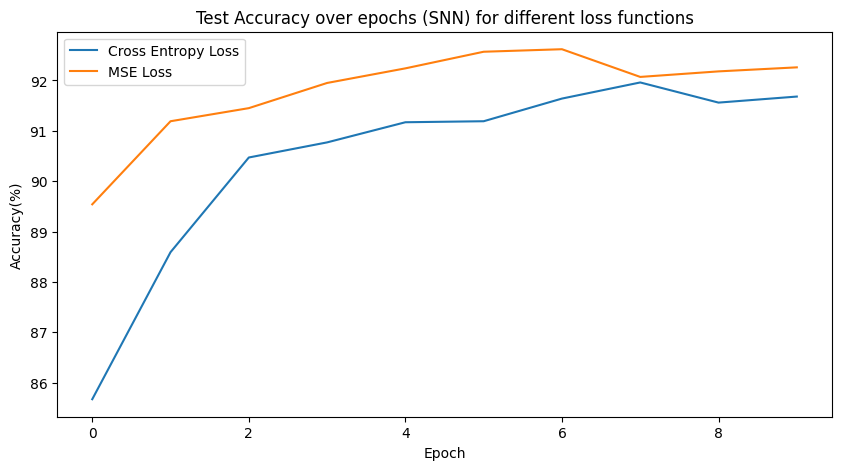

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), cross_entropy_loss_test_accuracy, label='Cross Entropy Loss')
plt.plot(range(epochs), mse_loss_test_accuracy, label='MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.title('Test Accuracy over epochs (SNN) for different loss functions')
plt.legend()
plt.show()

#### 4.3 FLOPs calculation (ANN FLOPs: 1 points, SNN FLOPs: 2 points)

One of the main advantages of SNN is its low power consumption. As stated in the class, a neuron which does not emit spikes will not add any computation when deployed to hardware. Calculate FLOPs in one forward pass for ANN and SNN.

Step-by-step instructions:

- Understand FLOPs calculation

  - **ANN FLOPs**: The formula for calculating FLOPs in a fully connected layer using ReLU activation is given by
  $$(2M-1)\times N+2N$$
  where $M$ is the input size and $N$ is the output size.

  - **SNN FLOPs**: The formula for a fully connected layer with LIF neuron activation in a single timestep is:
  $$(2M\times F-1) \times N + 2N$$
  where $F$ is the firing rate of previous layer.

- Recall the network design:
  - ANN: fc1 (28*28 -> 10) - ReLU - fc2 (10 -> 10)
  - SNN ($T=5$): fc1 (28*28 -> 10) - LIF - fc2 (10 -> 10) - LIF

- In order to calculate FLOPs of SNN, please pass every batch of test dataset to the model and finally calculate average FLOPs.

Feel free to change time steps in the simulation and share your findings in the report.

In [57]:
class SNN_Flops(nn.Module):
    def __init__(self, T, beta=0.8, z=1, threshold=1.0):
        super(SNN_Flops, self).__init__()
        self.T = T
        self.flatten = nn.Flatten()
        # 1st fully-connected layer
        self.fc1 = nn.Linear(28 * 28, 10)
        self.lif1 = LeakySurrogate(beta=beta, z=z, threshold=threshold)
        # 2nd fully-connected layer
        self.fc2 = nn.Linear(10, 10)
        # output layer neurons, whose firing rate will be served as the final prediction
        self.lif2 = LeakySurrogate(beta=beta, z=z, threshold=threshold)

    def init_mem(self, batch_size, feature_num):
        return nn.init.kaiming_uniform_(torch.empty(batch_size, feature_num)).to(device)

    # define the forward pass
    def forward(self, input_):
        # input size: [T, batch_size, 28, 28]

        self.lif1.mem = self.init_mem(input_.shape[1], 10)
        self.lif2.mem = self.init_mem(input_.shape[1], 10)

        output_spikes = 0
        flops = 0
        for t in range(self.T):
            x = input_[t] # input size: [batch_size, 28, 28]
            x = self.flatten(x) # input size: [batch_size, 28*28]
            batch_firing_rate = torch.mean(x.sum(dim=1)/(28*28))
            flops += (2 * 28 * 28* batch_firing_rate - 1) * 10 + 2 * 10
            x = self.fc1(x) # input size: [batch_size, 10]
            spk1 = self.lif1(x) # input size: [batch_size, 10]

            x = self.fc2(spk1) # input size: [batch_size, 10]
            spk2 = self.lif2(x) # input size: [batch_size, 10]
            batch_firing_rate = torch.mean(spk1.sum(dim=1)/10)
            flops += (2 * 10 * batch_firing_rate - 1) * 10 + 2 * 10
            output_spikes = output_spikes + spk2

        return output_spikes / self.T, flops.item()

def train_snn_average_flops(model, train_loader, criterion, optimizer, epoch, data_gen, T=50):
    # set the model to training mode
    model.train()
    running_loss = 0.0
    average_flops = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # clear the gradients
        optimizer.zero_grad()
        # move data to GPU
        data, target = data.to(device), target.to(device)
        target_onehot = F.one_hot(target, 10).float()
        output_fr, flops = model(data_gen(data, T))
        average_flops.append(flops)

        # compute the loss
        loss = criterion(output_fr, target_onehot)
        loss.backward()
        # update the weights
        optimizer.step()
        running_loss += loss.item()

    # compute average loss in each epoch
    average_loss = running_loss / len(train_loader)
    return average_loss, np.average(average_flops)

def test_snn_average_flops(model, test_loader, criterion, data_gen, T=50):
    # set the model to evaluation
    model.eval()
    test_loss = 0
    correct = 0
    average_flops = []
    # disable gradient calculation
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target_onehot = F.one_hot(target, 10).float()
            output_fr, flops = model(data_gen(data, T))
            average_flops.append(flops)
            # sum up batch loss
            test_loss += criterion(output_fr, target_onehot).item()
            # get the index of the max log-probability as the predicted category
            pred = output_fr.argmax(dim=1, keepdim=True)
            # compute correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # average test loss
    test_loss /= len(test_loader.dataset)
    # accuracy percentage
    accuracy = 100. * correct / len(test_loader.dataset)

    return accuracy, test_loss, np.average(average_flops)

def train_with_flops(z=1, beta=0.8, v_th=1.0, t=5, data_gen=gen_spike_data_bernoulli, epochs=10):
    model = SNN_Flops(T=t, beta=beta, z=z, threshold=v_th).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses_snn = []
    test_losses_snn = []
    test_accuracies_snn = []
    train_average_flops = []
    test_average_flops = []
    for epoch in range(epochs):
        train_loss, train_flop = train_snn_average_flops(model, train_loader, criterion, optimizer, epoch, data_gen, t)
        train_losses_snn.append(train_loss)
        train_average_flops.append(train_flop)
        accuracy, test_loss, test_flop = test_snn_average_flops(model, test_loader, criterion, data_gen, t)
        test_average_flops.append(test_flop)
        test_losses_snn.append(test_loss)
        test_accuracies_snn.append(accuracy)

    return test_accuracies_snn, train_average_flops, test_average_flops

In [58]:
_, train_flops, test_flops = train_with_flops()

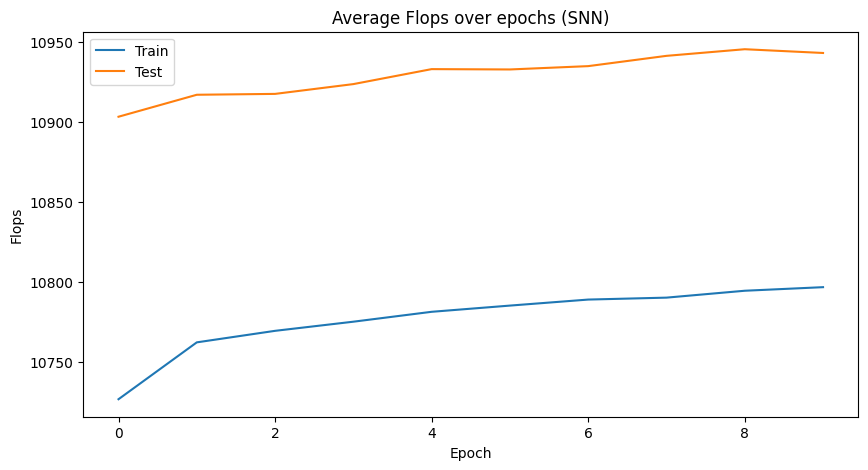

In [59]:
epochs = 10
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_flops, label='Train')
plt.plot(range(epochs), test_flops, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Flops')
plt.title('Average Flops over epochs (SNN)')
plt.legend()

In [60]:
average_flops_snn = np.average(test_flops)
average_flops_ann = \
((2 * 28 * 28 - 1) * 10 + 2 * 10 +  # 1st fully-connected layer
(2 * 10 - 1) * 10 + 2 * 10) # 2nd fully-connected layer

print(f'Average Flops for SNN with timesteps=5: {average_flops_snn}')
print(f'Average Flops for ANN: {average_flops_ann}')

Average Flops for SNN with timesteps=5: 10929.216193359374
Average Flops for ANN: 15900
